In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

2023-08-10 19:28:37.173800: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# tf.compat.v1.disable_eager_execution()

In [2]:
drugs_cell_lines_ic50_df = pd.read_csv("..//data//drugs_cell_lines_ic50.csv")

In [3]:
drugs_cell_lines_ic50_df.head()

,drug_id,Cancer_Cell_Line,IC50
0,1001,ACH-002137,7.258918
1,1004,ACH-002137,-3.802467
2,1005,ACH-002137,4.146364
3,1006,ACH-002137,3.171367
4,1007,ACH-002137,-4.959442


In [4]:
pubchem_drugs_smiles_df = pd.read_csv('..//data//drugs_smile_strings.csv')

In [5]:
pubchem_drugs_smiles_df.head()

,drug_id,Smiles
0,1242,COc1cc(O)c2c(c1)C=CCC(O)C(O)C(=O)C=CCC(C)OC2=O
1,179,O=c1[nH]cc(F)c(=O)[nH]1
2,86,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4c[nH]c5ccccc45)...
3,55,COc1cc(-c2nn(C3CCC(N4CCN(C(C)=O)CC4)CC3)c3ncnc...
4,1001,NC(=O)c1ncn(C2OC(COP(=O)(O)O)C(O)C2O)c1N


In [6]:
drugs_smiles_cell_lines_ic50_df = pd.merge(drugs_cell_lines_ic50_df, pubchem_drugs_smiles_df, 
                                             on = "drug_id")

In [7]:
drugs_smiles_cell_lines_ic50_df = drugs_smiles_cell_lines_ic50_df[["drug_id", "Cancer_Cell_Line", "Smiles", "IC50"]]

In [8]:
drugs_smiles_cell_lines_ic50_df.dtypes

drug_id               int64
Cancer_Cell_Line     object
Smiles               object
IC50                float64
dtype: object

In [9]:
drugs_smiles_cell_lines_ic50_df["drug_id"] = drugs_smiles_cell_lines_ic50_df["drug_id"].astype(object)

In [10]:
drugs_smiles_cell_lines_ic50_df.shape

(186789, 4)

In [12]:
# drugs_smiles_cell_lines_ic50_df.head()

In [13]:
import pickle

In [14]:
with open("..//data//drug_gcn_features.pickle", "rb") as f:
    dict_features = pickle.load(f)

In [16]:
len(dict_features)

238

In [15]:
with open("..//data//drug_gcn_normalized_adj_mats.pickle", "rb") as f:
    dict_normalized_adj_mats = pickle.load(f)

In [17]:
len(dict_normalized_adj_mats)

238

In [18]:
dualgcn_train = pd.read_csv("..//data//DualGCN_Embedding_train.csv")

In [19]:
dualgcn_test = pd.read_csv("..//data//DualGCN_Embedding_test.csv")

In [20]:
pubchem_to_drugs_df = pd.read_csv('../data/GDSC/1.Drug_listMon Jun 24 09_00_55 2019.csv')

In [21]:
pubchem_to_drugs_df = pubchem_to_drugs_df[["drug_id", "PubCHEM"]]

In [22]:
pubchem_to_drugs_df.dtypes

drug_id     int64
PubCHEM    object
dtype: object

In [23]:
import numpy as np

In [24]:
pubchem_to_drugs_df["PubCHEM"] = [val if str(val).isdigit() else np.nan for val in pubchem_to_drugs_df["PubCHEM"] ]

In [25]:
pubchem_to_drugs_df = pubchem_to_drugs_df.dropna()

In [26]:
pubchem_to_drugs_df.dtypes

drug_id     int64
PubCHEM    object
dtype: object

In [27]:
pubchem_to_drugs_df["drug_id"] = pubchem_to_drugs_df["drug_id"].astype(str)

In [24]:
# pubchem_to_drugs_df["drug_id"].values[0]

In [25]:
# '1001' in pubchem_to_drugs_df["drug_id"].values

In [28]:
with open("..//data//drug_gcn_normalized_adj_mats.pickle", "rb") as f:
    dict_normalized_adj_mats = pickle.load(f)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(drugs_smiles_cell_lines_ic50_df.drop(["IC50"],1), drugs_smiles_cell_lines_ic50_df["IC50"].values, 
                                                     test_size = 0.20, random_state = 42)

/tmp/ipykernel_4066411/747247744.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_valid, y_train, y_valid = train_test_split(drugs_smiles_cell_lines_ic50_df.drop(["IC50"],1), drugs_smiles_cell_lines_ic50_df["IC50"].values,


In [34]:
x_train.shape

(149431, 3)

In [35]:
x_valid.shape

(37358, 3)

In [36]:
dualgcn_train["Drug_ID"] = dualgcn_train["Drug_ID"].astype(str)

In [37]:
dualgcn_test["Drug_ID"] = dualgcn_test["Drug_ID"].astype(str)

In [38]:
pubchem_to_drugs_df.dtypes

drug_id    object
PubCHEM    object
dtype: object

In [39]:
dualgcn_train = pubchem_to_drugs_df.merge(dualgcn_train, left_on = ["PubCHEM"], right_on = ["Drug_ID"])

In [40]:
dualgcn_train = dualgcn_train[['Cell_Line', 'drug_id']]

In [41]:
dualgcn_test = pubchem_to_drugs_df.merge(dualgcn_test, left_on = ["PubCHEM"], right_on = ["Drug_ID"])

In [42]:
dualgcn_test = dualgcn_test[['Cell_Line', 'drug_id']]

In [43]:
dualgcn_train.head()

,Cell_Line,drug_id
0,ACH-000070,1242
1,ACH-000105,1242
2,ACH-000981,1242
3,ACH-000061,1242
4,ACH-000995,1242


In [44]:
dualgcn_train.dtypes

Cell_Line    object
drug_id      object
dtype: object

In [38]:
# x_train[

In [45]:
x_train.dtypes

drug_id             object
Cancer_Cell_Line    object
Smiles              object
dtype: object

In [40]:
# dualgcn_train

In [41]:
# x_train['drug_id'].values[0]

In [46]:
x_train['drug_id'] = x_train['drug_id'].astype(str)

In [47]:
x_valid['drug_id'] = x_valid['drug_id'].astype(str)

In [48]:
x_train_valid_feats = pd.concat([x_train, x_valid], ignore_index = True)

In [49]:
y_train_valid = pd.concat([pd.DataFrame(y_train.reshape(-1,1)), pd.DataFrame(y_valid.reshape(-1,1))], ignore_index = True)

In [50]:
combo_train_valid = pd.concat([x_train_valid_feats, y_train_valid], 1)

/tmp/ipykernel_4066411/1008667345.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  combo_train_valid = pd.concat([x_train_valid_feats, y_train_valid], 1)


In [51]:
combo_train_valid.head()

,drug_id,Cancer_Cell_Line,Smiles,0
0,1059,ACH-001368,COc1ccc(-c2ccc3c(N4CCOCC4C)nc(N4CCOCC4C)nc3n2)...,1.086644
1,255,ACH-000142,COCC(=O)NCC=Cc1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)c(...,4.227800
2,178,ACH-000218,COc1ccc(-c2cc3nccn3c(Nc3ncccc3C(N)=O)n2)cc1OC,0.067505
3,152,ACH-002155,COc1cc2ncnc(-n3nc(-c4ccccn4)nc3N)c2cc1OC,4.894550
4,1243,ACH-000277,COc1cc(C=CC(=O)N2CCC=CC2=O)cc(OC)c1OC,4.572953


In [52]:
combo_train_valid.columns = ['drug_id', 'Cancer_Cell_Line', 'Smiles', 'IC50']

In [53]:
# filter x_train x _valid here
x_y_train = combo_train_valid.merge(dualgcn_train, left_on = ['Cancer_Cell_Line','drug_id'], right_on = [ 'Cell_Line','drug_id'])

In [54]:
x_y_test = combo_train_valid.merge(dualgcn_test, left_on = ['Cancer_Cell_Line','drug_id'], right_on = [ 'Cell_Line','drug_id'])

In [55]:
x_y_test.shape

(17316, 5)

In [56]:
x_train.dtypes

drug_id             object
Cancer_Cell_Line    object
Smiles              object
dtype: object

In [53]:
# x_y_test

In [57]:
x_train, x_valid, y_train, y_valid = x_y_train.drop(["IC50", 'Cell_Line'],1), x_y_test.drop(["IC50", 'Cell_Line'], 1), x_y_train["IC50"].values, x_y_test["IC50"].values

/tmp/ipykernel_4066411/1750859165.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_valid, y_train, y_valid = x_y_train.drop(["IC50", 'Cell_Line'],1), x_y_test.drop(["IC50", 'Cell_Line'], 1), x_y_train["IC50"].values, x_y_test["IC50"].values
/tmp/ipykernel_4066411/1750859165.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_valid, y_train, y_valid = x_y_train.drop(["IC50", 'Cell_Line'],1), x_y_test.drop(["IC50", 'Cell_Line'], 1), x_y_train["IC50"].values, x_y_test["IC50"].values


In [58]:
x_train.shape

(69214, 3)

In [59]:
x_train.head()

,drug_id,Cancer_Cell_Line,Smiles
0,255,ACH-000142,COCC(=O)NCC=Cc1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)c(...
1,178,ACH-000218,COc1ccc(-c2cc3nccn3c(Nc3ncccc3C(N)=O)n2)cc1OC
2,1230,ACH-000090,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O
3,167,ACH-000348,NCC(=O)Nc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc3c(ccc4c...
4,1372,ACH-000914,CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc(...


In [57]:
# set(pubchem_to_drugs_df['PubCHEM'].values).intersection(dualgcn_train['Drug_ID'].values)

In [58]:
# dualgcn_train['Drug_ID'].values

In [59]:
# drugs_pubchem = pubchem_to_drugs_df.merge(dualgcn_train['Drug_ID'], left_on = ["PubCHEM"], right_on = ["Drug_ID"])["Drug_ID"].values

In [60]:
# to_keep_train = pubchem_to_drugs_df.merge(dualgcn_train['Drug_ID'], left_on = ["PubCHEM"], right_on = ["Drug_ID"])["Drug_ID"].values

In [61]:
# train_gcn_feats[0]

In [62]:
# dict_features

In [63]:
train_gcn_feats = []
train_adj_list = []
for drug_id in x_train["drug_id"].values:
    train_gcn_feats.append(dict_features[drug_id])
    train_adj_list.append(dict_normalized_adj_mats[drug_id])

In [64]:
valid_gcn_feats = []
valid_adj_list = []
for drug_id in x_valid["drug_id"].values:
    valid_gcn_feats.append(dict_features[drug_id])
    valid_adj_list.append(dict_normalized_adj_mats[drug_id])

In [65]:
import numpy as np

In [66]:
train_gcn_feats = np.array(train_gcn_feats).astype("float16")
valid_gcn_feats = np.array(valid_gcn_feats).astype("float16")

In [67]:
valid_gcn_feats.shape

(17316, 100, 75)

In [68]:
train_adj_list = np.array(train_adj_list).astype("float16")
valid_adj_list = np.array(valid_adj_list).astype("float16")

In [69]:
train_adj_list.shape

(69214, 100, 100)

In [70]:
# valid_adj_list[0,:, :]@valid_gcn_feats[0,:, :]

In [71]:
# dict_features[drug_id]

In [72]:
# train_gcn_feats.shape

In [73]:
# def gcn_feature_model(dataset): 
    

In [74]:
# dense_layer_gcn = tf.keras.layers.Dense(1)

In [75]:
# dense_out = dense_layer_gcn(valid_gcn_feats)

In [76]:
# dense_out = tf.keras.layers.Flatten()(dense_out)

In [77]:
# weights = tf.keras.layers.Softmax()(dense_out)

In [78]:
# weights = tf.keras.layers.Reshape((100, 1))(weights)

In [79]:
# valid_gcn_feats

In [80]:
# multiply_out = tf.keras.layers.Multiply()([valid_gcn_feats, weights])

In [81]:
# sum_lambda = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=1))

In [82]:
# sum_lambda(multiply_out)

In [83]:
# weights

In [84]:
# train_num_atoms = np.array(train_num_atoms).reshape(-1,1)
# valid_num_atoms = np.array(valid_num_atoms).reshape(-1,1)

In [85]:
# train_num_atoms.shape

In [86]:
# load models
# omic models
cancer_copy_number_model = tf.keras.models.load_model("..//Models//cancer_copy_number_model_no_norm_common")
cancer_cell_gen_expr_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_expr_model_no_norm_common")
cancer_cell_gen_methy_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_methy_model_no_norm")
cancer_cell_gen_mut_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_mut_model_no_norm")

2023-07-23 11:29:06.252591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2023-07-23 11:29:06.252624: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-23 11:29:06.252642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2518.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2023-07-23 11:29:06.253559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [87]:
# load models
# drug models
pubchem_drugs_rdkit_model = tf.keras.models.load_model("..//Models//pubchem_drugs_rdkit_model_no_norm")

In [88]:
from sklearn.preprocessing import StandardScaler

In [89]:
std = StandardScaler()

In [90]:
# extract drug features
drug_features_train = pubchem_drugs_rdkit_model(x_train["drug_id"].values).numpy().astype("float32")
drug_features_valid = pubchem_drugs_rdkit_model(x_valid["drug_id"].values).numpy().astype("float32")

# drug_features_train = pubchem_drugs_rdkit_model(x_train["drug_id"].values)
# drug_features_valid = pubchem_drugs_rdkit_model(x_valid["drug_id"].values)

In [91]:
drug_features_train.shape, drug_features_valid.shape

((69214, 106), (17316, 106))

In [92]:
# drug_features_train

In [93]:
np.isinf(drug_features_train).sum()

0

In [94]:
# drug_features_train.values

In [95]:
drug_features_train = std.fit_transform(drug_features_train)

In [96]:
drug_features_valid = std.transform(drug_features_valid)

In [97]:
# omics_copy_number_train

In [98]:
# x_train["Cancer_Cell_Line"].nunique()

In [99]:
# extract copy number features
omics_copy_number_train = cancer_copy_number_model(x_train["Cancer_Cell_Line"].values).numpy().astype("float16")
omics_copy_number_valid = cancer_copy_number_model(x_valid["Cancer_Cell_Line"].values).numpy().astype("float16")

In [100]:
# omics_copy_number_train

In [101]:
omics_copy_number_train.shape, omics_copy_number_valid.shape

((69214, 691), (17316, 691))

In [102]:
# extract gen expr features
omics_gen_expr_train = cancer_cell_gen_expr_model(x_train["Cancer_Cell_Line"].values).numpy().astype("float16")
omics_gen_expr_valid = cancer_cell_gen_expr_model(x_valid["Cancer_Cell_Line"].values).numpy().astype("float16")

In [103]:
omics_gen_expr_train.shape, omics_gen_expr_valid.shape

((69214, 691), (17316, 691))

In [104]:
# omics_gen_copy_number_gen_expr_train = np.concatenate([np.expand_dims(omics_copy_number_train, -1),
#                                                       np.expand_dims(omics_gen_expr_train, -1)], axis = -1)

In [105]:
# omics_gen_copy_number_gen_expr_train.shape

In [106]:
# omics_gen_copy_number_gen_expr_valid = np.concatenate([np.expand_dims(omics_copy_number_valid, -1),
#                                                       np.expand_dims(omics_gen_expr_valid, -1)], axis = -1)

In [107]:
# omics_gen_copy_number_gen_expr_valid.shape

In [108]:
# extract gen methylation features
omics_gen_methyl_train = cancer_cell_gen_methy_model(x_train["Cancer_Cell_Line"].values).numpy().astype("float16")
omics_gen_methyl_valid = cancer_cell_gen_methy_model(x_valid["Cancer_Cell_Line"].values).numpy().astype("float16")

In [109]:
omics_gen_methyl_train.shape, omics_gen_methyl_valid.shape

((69214, 808), (17316, 808))

In [110]:
# extract gen mutation features
with tf.device('/cpu:0'):
    omics_gen_mut_train = cancer_cell_gen_mut_model.predict(x_train["Cancer_Cell_Line"].values, verbose = 1, batch_size = 256).astype("float16")
    omics_gen_mut_valid = cancer_cell_gen_mut_model.predict(x_valid["Cancer_Cell_Line"].values, verbose = 1, batch_size = 256).astype("float16")

68/68 [==============================] - 0s 2ms/step


In [111]:
omics_gen_mut_train.shape, omics_gen_mut_valid.shape

((69214, 34673), (17316, 34673))

In [112]:
smile_strings_train = x_train["Smiles"].values.reshape(-1,1)
smile_strings_valid = x_valid["Smiles"].values.reshape(-1,1)

In [113]:
smile_strings_train.shape, smile_strings_valid.shape

((69214, 1), (17316, 1))

In [114]:
# selected_info_common_cell_lines = "../data/CCLE/cellline_list.txt"
# selected_info_common_genes = "../data/CCLE/gene_list.txt"

In [115]:
# PPI_file = "../data/PPI/PPI_network.txt"

In [116]:
# len(common_genes)

In [117]:
# 'CHN1' in common_genes

In [118]:
# with open(selected_info_common_cell_lines) as f:
#     common_cell_lines = [item.strip() for item in f.readlines()]
    
# with open("..//data//common_genes.pickle", "rb") as f:
#     common_genes = pickle.load(f)
    
# idx_dic={}
# for index, item in enumerate(common_genes):
#     idx_dic[item] = index

# ppi_adj_info = [[] for item in common_genes] 
# for line in open(PPI_file).readlines():
#     gene1,gene2 = line.split('\t')[0],line.split('\t')[1]
#     if (gene1 in common_genes) & (gene2 in common_genes):
#         if idx_dic[gene1]<=idx_dic[gene2]:
#             ppi_adj_info[idx_dic[gene1]].append(idx_dic[gene2])
#             ppi_adj_info[idx_dic[gene2]].append(idx_dic[gene1])

In [119]:
# len(ppi_adj_info)

In [120]:
# common_genes[:20]

In [121]:
# ppi_adj_info

In [122]:
# ppi_adj_info

In [123]:
# len(common_genes)

In [124]:
# celline_feature_folder = "../data/CCLE/omics_data"

In [125]:
# cellline_drug_pair = []
# with open(selected_info_common_cell_lines) as f:
#     common_cell_lines = [item.strip() for item in f.readlines()]
    
# # with open(selected_info_common_genes) as f:
# #     common_genes = [item.strip() for item in f.readlines()]
# dic_cell_line_feat = {}
# for each in common_cell_lines:
#     dic_cell_line_feat[each] = pd.read_csv('%s/%s.csv'%(celline_feature_folder, each), index_col=0).loc[common_genes].values

In [126]:
# common_genes[:20]

In [127]:
# dic_cell_line_feat[each].shape

In [128]:
# ppi_adj_info[0]

In [129]:
# nb_nodes

In [130]:
# nb_nodes = len(common_genes)

In [131]:
# def CelllineGraphAdjNorm(ppi_adj_info,common_genes = common_genes):
#     # with open(selected_info_common_genes) as f:
#     #     common_genes = [item.strip() for item in f.readlines()]
#     nb_nodes = len(common_genes)
#     adj_mat = np.zeros((nb_nodes,nb_nodes),dtype='float32')
#     # print(adj_mat.shape)
#     for i in range(len(ppi_adj_info)):
#         # print(i)
#         nodes = ppi_adj_info[i]
#         for each in nodes:
#             adj_mat[i,each] = 1
#     assert np.allclose(adj_mat,adj_mat.T)
#     norm_adj = NormalizeAdj(adj_mat)
#     return norm_adj 

In [132]:
# def NormalizeAdj(adj):
#     adj = adj + np.eye(adj.shape[0])
#     d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0).toarray()
#     a_norm = adj.dot(d).transpose().dot(d)
#     return a_norm

In [133]:
import scipy.sparse as sp

In [134]:
# ppi_adj = CelllineGraphAdjNorm(ppi_adj_info,common_genes)

In [135]:
# ppi_adj.shape

In [136]:
# ppi_adj = np.expand_dims(ppi_adj,0)

In [137]:
# ppi_adj.shape

In [138]:
# omics_gen_copy_number_gen_expr_train = (ppi_adj@omics_gen_copy_number_gen_expr_train)
# omics_gen_copy_number_gen_expr_valid = (ppi_adj@omics_gen_copy_number_gen_expr_valid)

In [139]:
# omics_gen_copy_number_gen_expr_train.shape

In [140]:
# omics_gen_copy_number_gen_expr_valid.shape

In [141]:
# const_input = tf.keras.layers.Input(tensor=ppi_adj, dtype=tf.float64)

In [142]:
# len(dic_cell_line_feat)

In [143]:
# ppi_adj.shape

In [144]:
# input_smiles_string = tf.keras.layers.Input(shape = (1,), dtype = tf.string)

In [145]:
# text_vec = tf.keras.layers.TextVectorization(standardize=None,
#     split='character', output_mode = "int")

# text_vec.adapt(smile_strings_train, batch_size = 100000)

In [146]:
# text_vec_output = text_vec(input_smiles_string)

In [147]:
# embedding_layer = tf.keras.layers.Embedding(len(text_vec.get_vocabulary()), 128)
# embedding_output = embedding_layer(text_vec_output)
# lstm_layer = tf.keras.layers.LSTM(64)
# lstm_output_smiles = lstm_layer(embedding_output)

In [148]:
# bottleneck_layer_smiles = tf.keras.layers.Dense(32, activation = "relu")

In [149]:
# bottleneck_layer_smiles_out = bottleneck_layer_smiles(lstm_output_smiles)

In [150]:
# input_rdkit = tf.keras.layers.Input(shape = (drug_features_train.shape[1],))

In [151]:
# dense_rdkit_layer = tf.keras.layers.Dense(64, activation = "relu")

In [152]:
# rdkit_embs = dense_rdkit_layer(input_rdkit)
# dense_rdkit_layer = tf.keras.layers.Dense(32, activation = "relu")
# rdkit_embs = dense_rdkit_layer(rdkit_embs)

In [153]:
input_gcn_features = tf.keras.layers.Input(shape = (100, 75))
input_norm_adj_mat = tf.keras.layers.Input(shape = (100, 100))
mult_1 = tf.keras.layers.Dot(1)([input_norm_adj_mat, input_gcn_features])
dense_layer_gcn = tf.keras.layers.Dense(256, activation = "relu")
dense_out = dense_layer_gcn(mult_1)
dense_out = tf.keras.layers.BatchNormalization()(dense_out)
dense_out = tf.keras.layers.Dropout(0.2)(dense_out)
mult_2 = tf.keras.layers.Dot(1)([input_norm_adj_mat, dense_out])
dense_layer_gcn = tf.keras.layers.Dense(256, activation = "relu")
dense_out = dense_layer_gcn(mult_2)
dense_out = tf.keras.layers.BatchNormalization()(dense_out)
dense_out = tf.keras.layers.Dropout(0.2)(dense_out)

dense_layer_gcn = tf.keras.layers.Dense(100, activation = "relu")
mult_3 = tf.keras.layers.Dot(1)([input_norm_adj_mat, dense_out])
dense_out = dense_layer_gcn(mult_3)
dense_out = tf.keras.layers.BatchNormalization()(dense_out)
dense_out = tf.keras.layers.Dropout(0.2)(dense_out)

dense_out = tf.keras.layers.GlobalAvgPool1D()(dense_out)

In [154]:
dense_out

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'global_average_pooling1d')>

In [155]:
# rdkit_with_smile_embs = tf.keras.layers.Concatenate()([rdkit_embs, bottleneck_layer_smiles_out, dense_out])

In [156]:
# drugs_final_emb_layer = tf.keras.layers.Dense(32, activation = "relu")

In [157]:
# drugs_smiles_rdkit_embs = drugs_final_emb_layer(dense_out)

In [158]:
# drugs_smiles_rdkit_embs

In [159]:
# drugs_smiles_rdkit_embs = tf.keras.layers.Dropout(0.25)(drugs_smiles_rdkit_embs)

In [160]:
# input_copy_number = tf.keras.layers.Input(shape = (omics_copy_number_train.shape[1],))

In [161]:
# input_copy_number = tf.keras.layers.Reshape((omics_copy_number_train.shape[1],1))(input_copy_number)

In [162]:
# copy_number_layer = tf.keras.layers.Dense(256, activation = "relu")

In [163]:
# copy_number_emb = copy_number_layer(input_copy_number)

In [164]:
# copy_number_layer = tf.keras.layers.Dense(128, activation = "relu")

In [165]:
# copy_number_emb = copy_number_layer(copy_number_emb)

In [166]:
input_gen_expr = tf.keras.layers.Input(shape = (omics_gen_expr_train.shape[1]))

In [167]:
# input_gen_expr = tf.keras.layers.Reshape((691,1))(input_gen_expr)

In [168]:
# input_cv_expr = tf.keras.layers.Concatenate(axis = -1)([input_copy_number, input_gen_expr])

In [169]:
# input_gen_expr

In [170]:
l1 = tf.keras.layers.Dense(256, activation = "tanh")(input_gen_expr)
l1 = tf.keras.layers.BatchNormalization()(l1)
l1 = tf.keras.layers.Dropout(0.2)(l1)
l1 = tf.keras.layers.Dense(100, activation = "relu")(l1)
# l2 = tf.keras.layers.Dense(128)(l1)
# l2 = tf.keras.layers.Dropout(0.2)(l2)
# mult_11 = tf.keras.layers.Dot(1)([const_input, l2])


In [345]:
# dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
# dense_out1 = dense_layer_gcn1(l2)
# dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
# dense_out1 = tf.keras.layers.Dropout(0.2)(dense_out1)
# # mult_21 = tf.keras.layers.Dot(1)([const_input, dense_out1])
# dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
# dense_out1 = dense_layer_gcn1(dense_out1)
# dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
# dense_out1 = tf.keras.layers.Dropout(0.2)(dense_out1)
# dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
# dense_out1 = dense_layer_gcn1(dense_out1)
# dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
# dense_out1 = tf.keras.layers.Dropout(0.2)(dense_out1)
# dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
# dense_out1 = dense_layer_gcn1(dense_out1)
# dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
# dense_out1 = tf.keras.layers.Dropout(0.2)(dense_out1)
# dense_out1 = tf.keras.layers.GlobalAvgPool1D()(dense_out1)

In [346]:
# dense_out1

In [347]:
# gen_expr_layer = tf.keras.layers.Dense(256, activation = "relu")

In [348]:
# gen_expr_emb = gen_expr_layer(input_gen_expr)
# gen_expr_layer = tf.keras.layers.Dense(128, activation = "relu")
# gen_expr_emb = gen_expr_layer(gen_expr_emb)

In [349]:
# omics_gen_methyl_train.shape

In [350]:
input_gen_methy = tf.keras.layers.Input(shape = (omics_gen_methyl_train.shape[1],))

In [351]:
gen_methy_layer = tf.keras.layers.Dense(256, activation = "tanh")

In [352]:
gen_methy_emb = gen_methy_layer(input_gen_methy)
gen_methy_emb = tf.keras.layers.BatchNormalization()(gen_methy_emb)
gen_methy_emb = tf.keras.layers.Dropout(0.2)(gen_methy_emb)

In [353]:
gen_methy_layer = tf.keras.layers.Dense(100, activation = "relu")
gen_methy_emb = gen_methy_layer(gen_methy_emb)

In [354]:
input_gen_mut = tf.keras.layers.Input(shape = (omics_gen_mut_train.shape[1],))

In [355]:
reshape_gen_mut = tf.keras.layers.Reshape((1, omics_gen_mut_train.shape[1], 1))

In [356]:
reshape_gen_mut = reshape_gen_mut(input_gen_mut)

In [357]:
gen_mut_layer = tf.keras.layers.Conv2D(50, (1, 700), strides=5, activation = "tanh")

In [358]:
gen_mut_emb = gen_mut_layer(reshape_gen_mut)

In [359]:
gen_mut_emb.shape

TensorShape([None, 1, 6795, 50])

In [360]:
pool_layer = tf.keras.layers.MaxPooling2D((1,5))

In [361]:
pool_out = pool_layer(gen_mut_emb)

In [362]:
pool_out

<KerasTensor: shape=(None, 1, 1359, 50) dtype=float32 (created by layer 'max_pooling2d_5')>

In [363]:
gen_mut_layer = tf.keras.layers.Conv2D(30, (1, 5), strides=2, activation = "relu")

In [364]:
gen_mut_emb = gen_mut_layer(pool_out)

In [365]:
gen_mut_emb 

<KerasTensor: shape=(None, 1, 678, 30) dtype=float32 (created by layer 'conv2d_6')>

In [366]:
pool_layer = tf.keras.layers.MaxPooling2D((1,10))

In [367]:
pool_out = pool_layer(gen_mut_emb)

In [368]:
pool_out

<KerasTensor: shape=(None, 1, 67, 30) dtype=float32 (created by layer 'max_pooling2d_6')>

In [369]:
flatten_layer = tf.keras.layers.Flatten()

In [370]:
flatten_out = flatten_layer(pool_out)

In [371]:
flatten_out

<KerasTensor: shape=(None, 2010) dtype=float32 (created by layer 'flatten_2')>

In [372]:
all_omics = tf.keras.layers.Concatenate()([gen_methy_emb, flatten_out, l1, dense_out])

In [373]:
all_omics

<KerasTensor: shape=(None, 2310) dtype=float32 (created by layer 'concatenate_1')>

In [374]:
x = tf.keras.layers.Dense(300,activation = 'tanh')(all_omics)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x,axis=-1))(x)
x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x,axis=1))(x)
x = tf.keras.layers.Conv2D(filters=30, kernel_size=(1,150),strides=(1, 1), activation = 'relu',padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1,2))(x)
x = tf.keras.layers.Conv2D(filters=10, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1,3))(x)
x = tf.keras.layers.Conv2D(filters=5, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1,3))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)

In [375]:
# last_omics_emb = tf.keras.layers.Dense(64, activation = "relu")

In [376]:
# final_omics_emb = last_omics_emb(all_omics)

In [377]:
# final_omics_emb = tf.keras.layers.Dropout(0.25)(final_omics_emb)

In [378]:
# final_drugs_omics = tf.keras.layers.Concatenate()([drugs_smiles_rdkit_embs, x])

In [379]:
# final_emb_layer = tf.keras.layers.Dense(32, activation = "relu")

In [380]:
# final_emb = final_emb_layer(final_drugs_omics)

In [381]:
# final_emb = tf.keras.layers.Dropout(0.15)(final_emb)

In [382]:
final_out_layer = tf.keras.layers.Dense(1)

In [383]:
final_out = final_out_layer(x)

In [384]:
simplecdr = tf.keras.models.Model([input_gcn_features, input_norm_adj_mat,input_gen_expr,
                                   input_gen_methy, input_gen_mut], final_out)

In [385]:
simplecdr.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 75)]    0           []                               
                                                                                                  
 dot_3 (Dot)                    (None, 100, 75)      0           ['input_7[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 100, 256)     19456       ['dot_3[0][0]']            

In [386]:
simplecdr.compile(loss = tf.keras.losses.MeanSquaredError(), 
                    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
                    metrics = [tf.keras.metrics.RootMeanSquaredError()])

/home/statgrads/vpiyush2/.conda/envs/tensorflow-gpu-2.9-custom/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [387]:
# len(smile_strings_train)

In [388]:
import random

In [389]:
# random_idx = random.sample(range(0,len(smile_strings_train)), k = 125000)

In [390]:
# random_idx = list(random_idx)

In [391]:
# smile_strings_train.shape

In [392]:
# smile_strings_train[:100000,:]

In [393]:
# input11 = np.array([ppi_adj[0,:,:] for i in range(0,1000)])

In [394]:
# input11.shape

In [221]:
# omics_gen_methyl_train[:1000,:].shape

In [396]:
history = simplecdr.fit([train_gcn_feats[:80000,:, :], train_adj_list[:80000,:, :],
                         omics_gen_expr_train[:80000,:], 
                         omics_gen_methyl_train[:80000,:], omics_gen_mut_train[:80000,:]], y_train.reshape(-1,1)[:80000,:], 
                         
          batch_size = 64, epochs = 10000, verbose = 1,
                         
          validation_data=([ valid_gcn_feats, valid_adj_list,
                           omics_gen_expr_valid, 
                           omics_gen_methyl_valid, omics_gen_mut_valid], y_valid.reshape(-1,1)),
                         

        callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights=True,
                                                       mode = "min"), 
         validation_batch_size = 512, shuffle = True)

Epoch 1/10000


2023-07-23 08:55:21.147842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-23 08:55:21.147877: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-23 08:55:21.396731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1082/1082 [==============================] - 24s 17ms/step - loss: 3.9863 - root_mean_squared_error: 1.9966 - val_loss: 2.3077 - val_root_mean_squared_error: 1.5191
Epoch 2/10000
1082/1082 [==============================] - 12s 11ms/step - loss: 2.5951 - root_mean_squared_error: 1.6109 - val_loss: 2.0774 - val_root_mean_squared_error: 1.4413
Epoch 3/10000
1082/1082 [==============================] - 12s 11ms/step - loss: 2.3616 - root_mean_squared_error: 1.5367 - val_loss: 1.8700 - val_root_mean_squared_error: 1.3675
Epoch 4/10000
1082/1082 [==============================] - 12s 11ms/step - loss: 2.2246 - root_mean_squared_error: 1.4915 - val_loss: 2.3758 - val_root_mean_squared_error: 1.5414
Epoch 5/10000
1082/1082 [==============================] - 12s 11ms/step - loss: 2.1383 - root_mean_squared_error: 1.4623 - val_loss: 1.7062 - val_root_mean_squared_error: 1.3062
Epoch 6/10000
1082/1082 [==============================] - 12s 11ms/step - loss: 2.0754 - root_mean_squared_error: 1.44

In [397]:
simplecdr.save("..//Models//simple_cdr_more_dropout")

INFO:tensorflow:Assets written to: ..//Models//simple_cdr_more_dropout/assets


INFO:tensorflow:Assets written to: ..//Models//simple_cdr_more_dropout/assets


In [171]:
simplecdr = tf.keras.models.load_model("..//Models//simple_cdr_more_dropout")

In [172]:
val_preds = simplecdr.predict([ valid_gcn_feats, valid_adj_list,
                           omics_gen_expr_valid, 
                           omics_gen_methyl_valid, omics_gen_mut_valid])

542/542 [==============================] - 14s 25ms/step


In [181]:
from sklearn.metrics import mean_squared_error

In [183]:
np.sqrt(mean_squared_error(val_preds, y_valid))

1.0763594111430508

In [173]:
import matplotlib.pyplot as plt

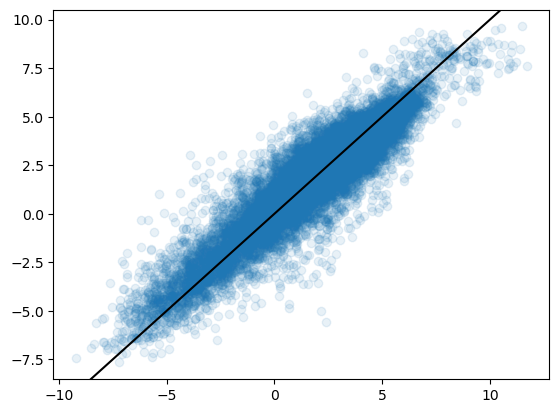

In [174]:
plt.scatter(y_valid.reshape(-1,1), val_preds, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.show()

In [175]:
from scipy.stats import pearsonr

In [176]:
res = pearsonr(y_valid.tolist(), val_preds.tolist())

In [177]:
res

(array([0.9249177428104566], dtype=object), 0.0)

In [178]:
res[0][0]

0.9249177428104566